In [18]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Load Data

In [19]:
proj_path = Path(os.getcwd()).parent.absolute()
churn_filepath = proj_path/'data'/'Churn_Modelling.csv'

In [20]:
df = pd.read_csv(churn_filepath)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [21]:
df.shape

(10000, 14)

In [22]:
# Are there missing values?
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [23]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [24]:
cat_cols = ['Geography', 'Gender']
num_cols = ['CreditScore', 'Age', 'Tenure', 
               'Balance', 'NumOfProducts', 'HasCrCard',
               'IsActiveMember', 'EstimatedSalary']
targ_col = 'Exited'

# Data Split

In [25]:
X, y = df[cat_cols + num_cols], df[targ_col]

In [26]:
y.mean()

0.2037

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train

In [28]:
random_state = 42
train_params = {'n_estimators': 100, 'max_depth': 10}

# Select algorithm
clf = RandomForestClassifier(random_state=random_state,  **train_params)
# clf = LGBMClassifier(random_state=random_state, **train_params)
# clf = XGBClassifier(random_state=random_state, **train_params)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler())
        ]
    )
categorical_transformer = OrdinalEncoder()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", clf)]
    )

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['Geography', 'Gender'])])),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

# Evaluate

In [29]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, f1_score,
                             roc_auc_score)
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance

In [30]:
from dvclive import Live

live = Live(dir="eval_plots")

If you have a DVC Pipeline, run it with `dvc exp run`.
If you are using DVCLive alone, use `save_dvc_exp=True`.


In [31]:
# Get predictions 

y_prob = model.predict_proba(X_test)
y_pred = y_prob[:, 1] >= 0.5

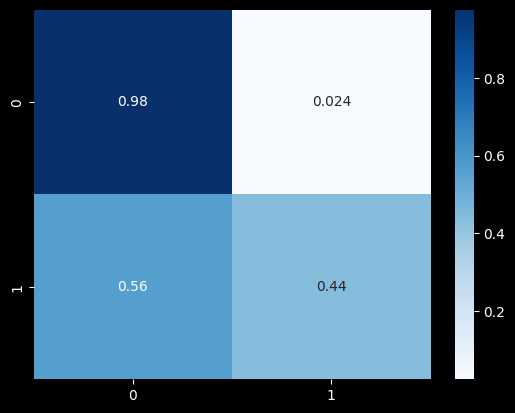

In [62]:
# Plot Confusion Matrix 

cm = confusion_matrix(y_test, y_pred, normalize='true') 
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues) 

CM_IMAGE_PATH = 'cm.png'
plt.savefig(CM_IMAGE_PATH)

In [ ]:
# LIVE: Log an existing image

live.log_image("cm.png", CM_IMAGE_PATH)

In [78]:
# Save sklearn plot 

live.log_sklearn_plot("confusion_matrix", y_test, y_pred)

In [63]:
# Calculate Metrics

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])

print(f1)
print(roc_auc)

0.5688073394495413
0.8607069275362611


In [65]:
# LIVE: Log an existing image

live.log_metric('f1', f1)
live.log_metric('roc_auc', roc_auc)


### Feature Importance

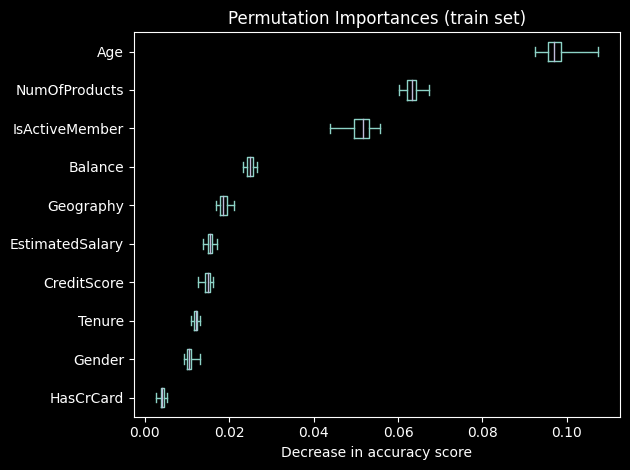

In [108]:
# Calculate Feature Importance for Train

perm = permutation_importance(
    model, X_train, y_train, n_repeats=30, random_state=0, n_jobs=2)


sorted_importances_idx = perm.importances_mean.argsort()
feat_imp_train = pd.DataFrame(
    perm.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

fig, ax = feat_imp_train.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [119]:
FEAT_IMP_TRAIN_PATH = 'feat_imp_train.png'

ax.figure.savefig(FEAT_IMP_TRAIN_PATH)

live.log_image("matplotlib.png", FEAT_IMP_TRAIN_PATH)

Links 
- [Docs: Generates a receiver operating characteristic (ROC) curve plot](https://dvc.org/doc/dvclive/live/log_sklearn_plot?tab=confusion_matrix)


In [35]:
(feat_imp_train
 .agg(['mean', 'std'], axis=0)
 .T.sort_values(by='mean', ascending=False)
#  .to_csv('feat_imp_train.csv', index=True)
)

,mean,std
Age,0.097436,0.003327
NumOfProducts,0.063378,0.001811
IsActiveMember,0.051173,0.002861
Balance,0.024982,0.000937
Geography,0.018671,0.001100
EstimatedSalary,0.015400,0.000823
CreditScore,0.014893,0.000900
Tenure,0.012076,0.000614
Gender,0.010702,0.000935
HasCrCard,0.004164,0.000571


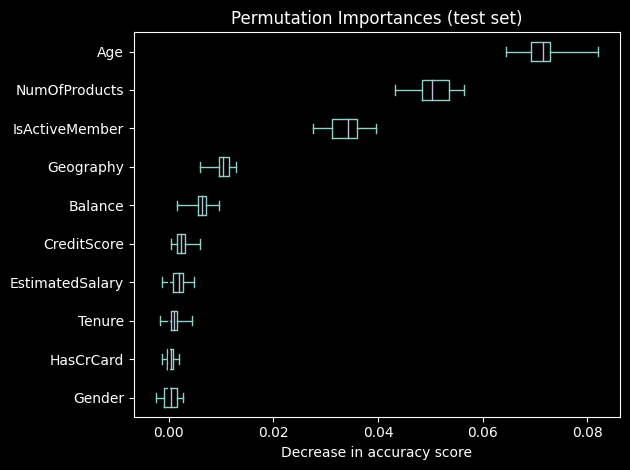

In [36]:
# Calculate Feature Importance for Test

perm = permutation_importance(
    model, X_test, y_test, n_repeats=30, random_state=0, n_jobs=2)


sorted_importances_idx = perm.importances_mean.argsort()
feat_imp_test = pd.DataFrame(
    perm.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = feat_imp_test.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [37]:
(feat_imp_test
 .agg(['mean', 'std'], axis=0)
 .T.sort_values(by='mean', ascending=False)
#  .to_csv('feat_imp_test.csv', index=True)
)

,mean,std
Age,0.071427,0.004399
NumOfProducts,0.050920,0.003432
IsActiveMember,0.033760,0.003217
Geography,0.010493,0.001435
Balance,0.006360,0.001730
CreditScore,0.002493,0.001281
EstimatedSalary,0.001773,0.001396
Tenure,0.001013,0.001311
HasCrCard,0.000307,0.000851
Gender,0.000267,0.001534


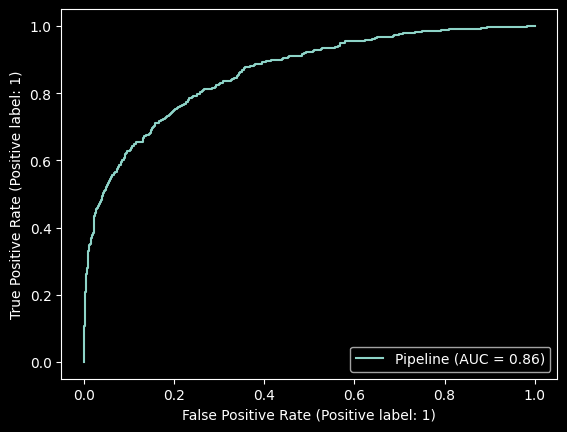

In [102]:
# Plot ROC-AUC Curve

# fig, ax = plt.subplots()
svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
# svc_disp.plot()
# plt.savefig('../eval_plots/roc_auc.png')
# plt.show()

In [83]:
# LIVE: Save ROC Plot

live.log_sklearn_plot("roc", y_test, y_prob[:, 1])

Links 
- [Docs: Generates a receiver operating characteristic (ROC) curve plot](https://dvc.org/doc/dvclive/live/log_sklearn_plot?tab=confusion_matrix)


## Save Predictions

In [39]:
# Save Predictions

df_test = X_test.copy(deep=True)
df_test['true'] = y_test
df_test['pred'] = y_pred
df_test['prob'] = y_prob[:, 1]
df_test

,Geography,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,true,pred,prob
6252,Germany,Male,596,32,3,96709.07,2,0,0,41788.37,0,False,0.033832
4684,France,Male,623,43,1,0.00,2,1,1,146379.30,0,False,0.041014
1731,Spain,Female,601,44,4,0.00,2,1,0,58561.31,0,False,0.116535
4742,Germany,Male,506,59,8,119152.10,2,1,1,170679.74,0,False,0.154570
4521,Spain,Female,560,27,7,124995.98,1,1,1,114669.79,0,False,0.123252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4862,Spain,Female,645,55,1,133676.65,1,0,1,17095.49,0,False,0.285888
7025,Spain,Female,569,51,3,0.00,3,1,0,75084.96,1,True,0.832578
7647,France,Male,768,25,0,78396.08,1,1,1,8316.19,0,False,0.071916
7161,France,Female,690,36,6,110480.48,1,0,0,81292.33,0,False,0.145204
